# Sales Prediction for Corporation Favorita Utilizing Time Series, XGBoost and Linear Regression

#### Group Member: Zixuan Jia, Tianbo Li, Zhankun Hu

# 1. Introduction

### 1.1 Project objectives

This project objective is to utilize linear regression, time series and XGBoost to predict sales for stores of Corporación Favorita, a large Ecuadorian-based grocery retailer and to compare the prediction accuracy of aforementioned models.

### 1.2 Project significance

The project has strategic value as to provide valuable information for Corporación Favorita. Accurate demand prediction can improve revenue and manage cost in fields like marketing, inventory and purchasing. If the demand prediction is higher than the actual demand, the stores might face loss due to overstocked, perishable goods. However, if the sales prediction is lower than the actual number, the stores might lose revenues they could have earned because supply cannot meet demand, leaving money on the table.

Also, the project can provide information to tailor the products to the customers’ preferences and needs, improving overall customer satisfaction level by incorporating and analyzing data of demographic factor and location of the stores.

Moreover, the project can offer strategic marketing information to understand the impact of promotion and holidays have on sales.
The methodology and models in the project can also be utilized for demand prediction for other companies like e-commerce companies, providing business suggestions.

### 1.3 Literature review

Demand prediction is critical for grocery stores, because demand prediction offers strategic value in projecting future revenue and in inventory decision making. Economists have done abundant research in demand prediction for companies to prove the accuracy of prediction model. 

(Kotler P., Keller K.L., 2011) summarized that in markets, demand is primarily influenced by social, cultural, psychological and personality factors.

Economists have been actively looking for methods to accurately predict demand, incorporating variables and analyzing the influences of different factors for years with trials and errors.

(Morphet,1991) used regression analysis to show the importance of grocery store location to the store’s performance, and Morphet concluded that population density as well as the demographic along with geographic variables played an important part in affecting the sales performance. 

With the technological advance and more interdisciplinary research, researchers started to incorporate computer science and statistics into modeling for demand prediction and analyzing consumer behaviors. 

(Bajari, Nekipelov, P.Ryan and Yang, 2015) applied several popular machine learning approaches on the data from IRI Marketing Research to predict grocery data, and found out that machine learning approaches can produce superior out-of-sample prediction accuracy while holding in-sample error comparable as compared to a standard linear combination of the underlying models.

# 2. Data

### 2.1 Data Source

Data source: Data is provided by Corporación Favorita and found on Kaggle. https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data

Six files (excluding test file) are provided. Details will be explained below.

File Descriptions and Data Field Information:

Train.csv:
1. Training data, which includes the target unit_sales by date, store_nbr, and item_nbr and a unique id to label rows.
2. The target unit_sales can be integer (e.g., a bag of chips) or float (e.g., 1.5 kg of cheese).
3. Negative values of unit_sales represent returns of that particular item.
4. The onpromotion column tells whether that item_nbr was on promotion for a specified date and store_nbr.
5. Approximately 16% of the onpromotion values in the file are NAN

Stores.csv:
1. Store metadata, including city, state, type, and cluster.
2. Cluster is a grouping of similar stores.

test.csv:
1. Test data, with the date, store_nbr, item_nbr combinations that are to be predicted, along with the onpromotion information
2. The public/private leaderboard is based on time. All items in the public split included in the private split.

transactions.csv:
1. The count of sales transactions for each date, store_nbr combination. Only included for the training data timeframe.

oil.csv:
1. Daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it’s economical health is highly vulnerable to shocks in oil prices.)

holidays_events.csv:
1. Holidays and Events, with metadata
2. Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

Sample_submission.csv:
1. A sample submission file in the correct format.

### 2.2 Importing Libraries and Loading data

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [55]:
df_holiday_events = pd.read_csv('holidays_events.csv',parse_dates =['date'])
df_oil = pd.read_csv('oil.csv',parse_dates =['date'])
df_sample_submission = pd.read_csv('sample_submission.csv')
df_stores = pd.read_csv('stores.csv')
df_test = pd.read_csv('test.csv',parse_dates =['date'])
df_train = pd.read_csv('train.csv',parse_dates =['date'])
df_transactions = pd.read_csv('transactions.csv',parse_dates =['date'])

### 2.3 Exploratory Data Analysis 

This part is for checking missing variables, merging datasets and statistics summary.

In [56]:
# helper function 

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def check_df(dataframe):
    print('*'*30+'Name of dataframe'+'*'*30)
    print(get_df_name(dataframe))
    print('*'*30+'Shape of dataframe'+'*'*30)
    print(dataframe.shape)
    print('\n'+'*'*30+'Head of dataframe'+'*'*30)
    print(dataframe.head())
    print('\n'+'*'*30+'Tail of dataframe'+'*'*30)
    print(dataframe.tail())
    print('\n'+'*'*30+'Concise summary of dataframe'+'*'*30)
    print(dataframe.info())
    print('\n'+'*'*30+'Check for missing values'+'*'*30)
    print(dataframe.isnull().sum())
    print('\n'+'*'*30+'Check dataframe for numeric and categorical variables'+'*'*30)
    
    numeric_variables = dataframe.select_dtypes(include=[np.number])
    categorical_variables = dataframe.select_dtypes(exclude=[np.number])

    print('Numeric variables in the given dataframe : ',numeric_variables.shape[1])
    print('Categorical variables in the givne dataframe:',categorical_variables.shape[1])

### 2.3.1 Preliminary Statistics summary

In [57]:
check_df(df_holiday_events)

******************************Name of dataframe******************************
df_holiday_events
******************************Shape of dataframe******************************
(350, 6)

******************************Head of dataframe******************************
        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  

******************************Tail of dataframe******************************
          date        type    locale locale_name description  transferred
345 2017-12-2

In [58]:
# rename the column name for oil dataframe.
df_oil.rename(columns={'dcoilwtico':'oil_price'}, inplace=True)
check_df(df_oil)

******************************Name of dataframe******************************
df_oil
******************************Shape of dataframe******************************
(1218, 2)

******************************Head of dataframe******************************
        date  oil_price
0 2013-01-01        NaN
1 2013-01-02      93.14
2 2013-01-03      92.97
3 2013-01-04      93.12
4 2013-01-07      93.20

******************************Tail of dataframe******************************
           date  oil_price
1213 2017-08-25      47.65
1214 2017-08-28      46.40
1215 2017-08-29      46.46
1216 2017-08-30      45.96
1217 2017-08-31      47.26

******************************Concise summary of dataframe******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1218 non-null   datetime64[ns]
 1   oil_price  1175 non-

In [59]:
check_df(df_stores)

******************************Name of dataframe******************************
df_stores
******************************Shape of dataframe******************************
(54, 5)

******************************Head of dataframe******************************
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

******************************Tail of dataframe******************************
    store_nbr       city       state type  cluster
49         50     Ambato  Tungurahua    A       14
50         51  Guayaquil      Guayas    A       17
51         52      Manta      Manabi    A       11
52         53      

In [60]:
check_df(df_test)

******************************Name of dataframe******************************
df_test
******************************Shape of dataframe******************************
(28512, 5)

******************************Head of dataframe******************************
        id       date  store_nbr      family  onpromotion
0  3000888 2017-08-16          1  AUTOMOTIVE            0
1  3000889 2017-08-16          1   BABY CARE            0
2  3000890 2017-08-16          1      BEAUTY            2
3  3000891 2017-08-16          1   BEVERAGES           20
4  3000892 2017-08-16          1       BOOKS            0

******************************Tail of dataframe******************************
            id       date  store_nbr                      family  onpromotion
28507  3029395 2017-08-31          9                     POULTRY            1
28508  3029396 2017-08-31          9              PREPARED FOODS            0
28509  3029397 2017-08-31          9                     PRODUCE            1
28510 

In [61]:
check_df(df_train)

******************************Name of dataframe******************************
df_train
******************************Shape of dataframe******************************
(3000888, 6)

******************************Head of dataframe******************************
   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0

******************************Tail of dataframe******************************
              id       date  store_nbr                      family     sales  \
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PROD

In [62]:
check_df(df_transactions)

******************************Name of dataframe******************************
df_transactions
******************************Shape of dataframe******************************
(83488, 3)

******************************Head of dataframe******************************
        date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922

******************************Tail of dataframe******************************
            date  store_nbr  transactions
83483 2017-08-15         50          2804
83484 2017-08-15         51          1573
83485 2017-08-15         52          2255
83486 2017-08-15         53           932
83487 2017-08-15         54           802

******************************Concise summary of dataframe******************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns

In [63]:
check_df(df_stores)

******************************Name of dataframe******************************
df_stores
******************************Shape of dataframe******************************
(54, 5)

******************************Head of dataframe******************************
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

******************************Tail of dataframe******************************
    store_nbr       city       state type  cluster
49         50     Ambato  Tungurahua    A       14
50         51  Guayaquil      Guayas    A       17
51         52      Manta      Manabi    A       11
52         53      

### 2.3.2 Comprehensive statistics summary: Clustering and plotting store data

This part will cluster and plot the number of stores under multiple categories: type, geographic factor (city and sate).

In [64]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [65]:
df_stores.type.value_counts()

D    18
C    15
A     9
B     8
E     4
Name: type, dtype: int64

In [13]:
df_stores.state.value_counts()

Pichincha                         19
Guayas                            11
Santo Domingo de los Tsachilas     3
Azuay                              3
Manabi                             3
Cotopaxi                           2
Tungurahua                         2
Los Rios                           2
El Oro                             2
Chimborazo                         1
Imbabura                           1
Bolivar                            1
Pastaza                            1
Santa Elena                        1
Loja                               1
Esmeraldas                         1
Name: state, dtype: int64

In [14]:
df_stores.city.value_counts()

Quito            18
Guayaquil         8
Cuenca            3
Santo Domingo     3
Manta             2
Latacunga         2
Machala           2
Ambato            2
Quevedo           1
Esmeraldas        1
Loja              1
Libertad          1
Playas            1
Daule             1
Babahoyo          1
Salinas           1
Puyo              1
Guaranda          1
Ibarra            1
Riobamba          1
Cayambe           1
El Carmen         1
Name: city, dtype: int64

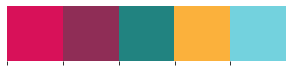

In [70]:
# Set Color Palettes for the notebook
my_color_palette = ["#d81159","#8f2d56","#218380","#fbb13c","#73d2de"]
sns.palplot(sns.color_palette(my_color_palette))

# Set Style
#sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

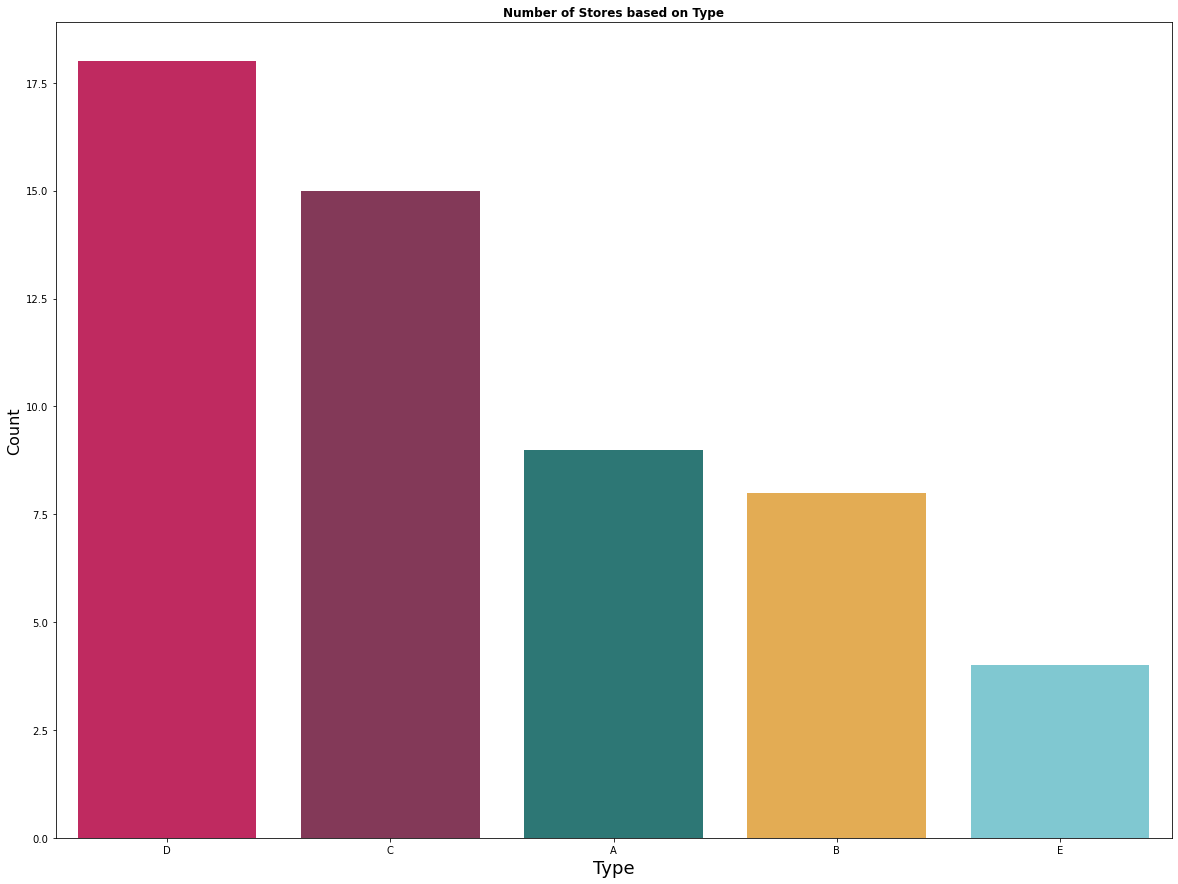

In [71]:
plt.figure(figsize=(20, 15))
sns.countplot(data=df_stores, x='type', order=df_stores.type.value_counts().index,palette=my_color_palette)
plt.title('Number of Stores based on Type',fontweight="bold")
plt.xlabel('Type', fontsize=18)
plt.ylabel('Count', fontsize=16)
plt.show()

Text(0.5, 0, 'Count')

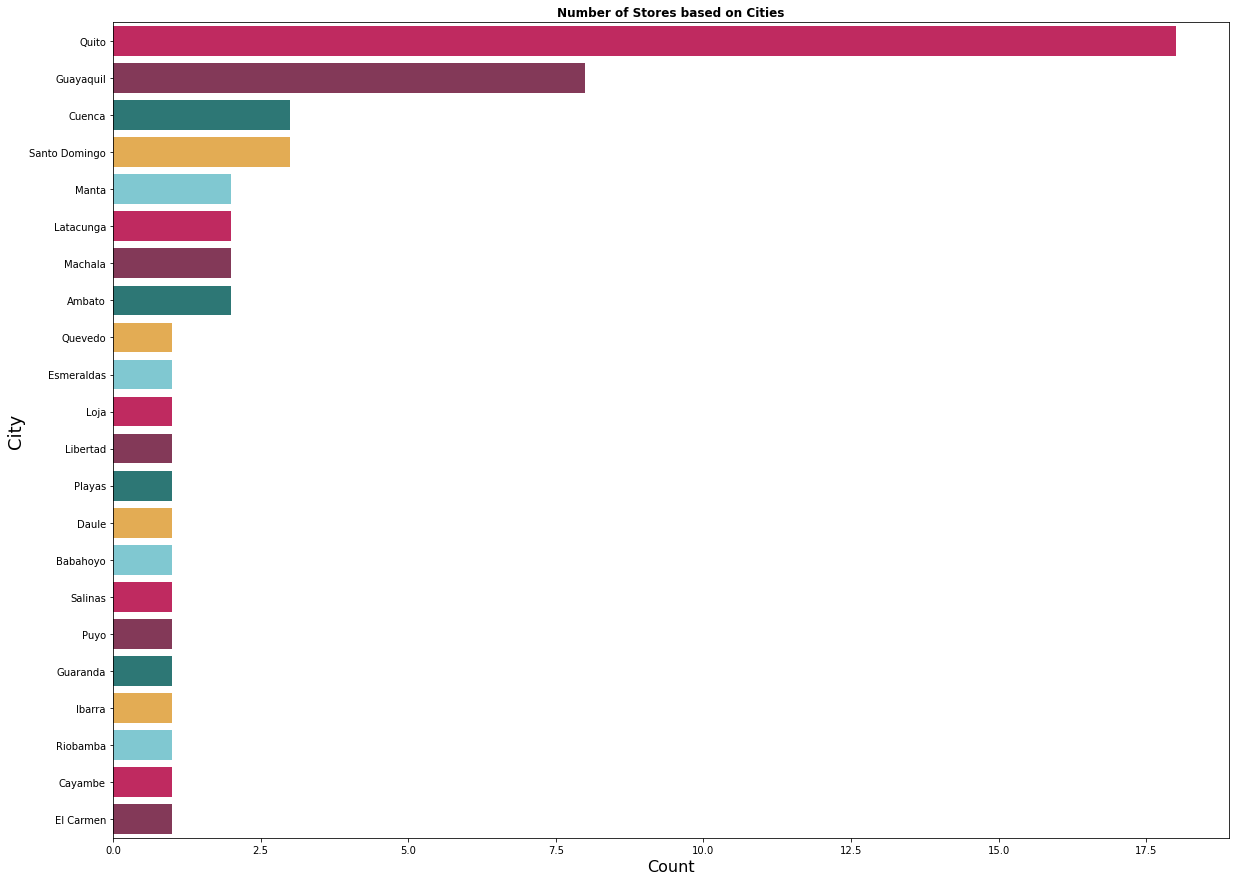

In [72]:
plt.figure(figsize=(20, 15))

sns.countplot(data=df_stores, y='city', 
              order=df_stores.city.value_counts().index,
              palette=my_color_palette,
              )
plt.title('Number of Stores based on Cities',fontweight="bold")
plt.ylabel('City', fontsize=18)
plt.xlabel('Count', fontsize=16)

Text(0.5, 0, 'Count')

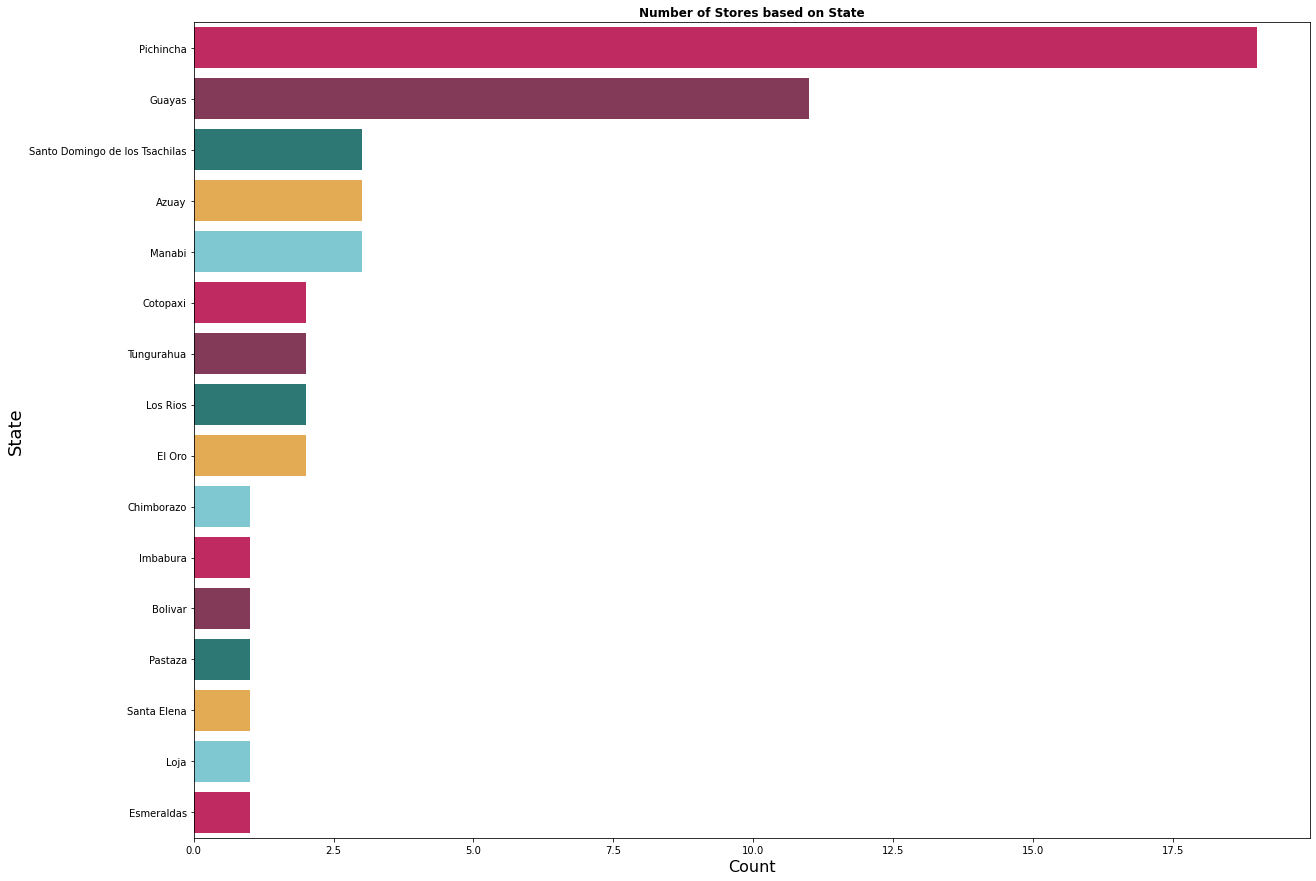

In [73]:
plt.figure(figsize=(20, 15))

sns.countplot(data=df_stores, y='state', 
              order=df_stores.state.value_counts().index,
              palette=my_color_palette,
              )
plt.title('Number of Stores based on State',fontweight="bold")
plt.ylabel('State', fontsize=18)
plt.xlabel('Count', fontsize=16)

### 2.3.3 Merging datasets

In [74]:
# combine dataframes
train = df_train.merge(df_oil, on='date')
test = df_train.merge(df_oil, on='date') 
    
train = train.merge(df_holiday_events[['date', 'type', 'transferred']], on='date')
train = train.merge(df_stores, on='store_nbr')
train.rename(columns={'type_x':'holiday_type', 'type_y':'store_type'}, inplace=True)

### 2.3.4 Statistics Summary: Plotting Distribution of Sales

This part will plot distribution of sales considering product,state and city using the merged dataset above.

In [75]:
train['Year'] = train.date.dt.year
train['Year-Month'] = train['date'].apply(lambda x : x.strftime('%Y-%m'))
train['Month'] = train.date.dt.month
train['Day'] = train.date.dt.day

In [76]:
train

,id,date,store_nbr,family,sales,onpromotion,oil_price,holiday_type,transferred,city,state,store_type,cluster,Year,Year-Month,Month,Day
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
1,1,2013-01-01,1,BABY CARE,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
2,2,2013-01-01,1,BEAUTY,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
4,4,2013-01-01,1,BOOKS,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352831,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Holiday,False,Quito,Pichincha,B,6,2017,2017-08,8,15
352832,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Holiday,False,Quito,Pichincha,B,6,2017,2017-08,8,15
352833,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Holiday,False,Quito,Pichincha,B,6,2017,2017-08,8,15
352834,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Holiday,False,Quito,Pichincha,B,6,2017,2017-08,8,15


In [77]:
test

,id,date,store_nbr,family,sales,onpromotion,oil_price
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,NaN
...,...,...,...,...,...,...,...
2143741,3000883,2017-08-15,9,POULTRY,438.133,0,47.57
2143742,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57
2143743,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57
2143744,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57


In [78]:
check_df(train)

******************************Name of dataframe******************************
__
******************************Shape of dataframe******************************
(352836, 17)

******************************Head of dataframe******************************
   id       date  store_nbr      family  sales  onpromotion  oil_price  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0        NaN   
1   1 2013-01-01          1   BABY CARE    0.0            0        NaN   
2   2 2013-01-01          1      BEAUTY    0.0            0        NaN   
3   3 2013-01-01          1   BEVERAGES    0.0            0        NaN   
4   4 2013-01-01          1       BOOKS    0.0            0        NaN   

  holiday_type  transferred   city      state store_type  cluster  Year  \
0      Holiday        False  Quito  Pichincha          D       13  2013   
1      Holiday        False  Quito  Pichincha          D       13  2013   
2      Holiday        False  Quito  Pichincha          D       13  2013   
3  

In [79]:
check_df(test)

******************************Name of dataframe******************************
_
******************************Shape of dataframe******************************
(2143746, 7)

******************************Head of dataframe******************************
   id       date  store_nbr      family  sales  onpromotion  oil_price
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0        NaN
1   1 2013-01-01          1   BABY CARE    0.0            0        NaN
2   2 2013-01-01          1      BEAUTY    0.0            0        NaN
3   3 2013-01-01          1   BEVERAGES    0.0            0        NaN
4   4 2013-01-01          1       BOOKS    0.0            0        NaN

******************************Tail of dataframe******************************
              id       date  store_nbr                      family     sales  \
2143741  3000883 2017-08-15          9                     POULTRY   438.133   
2143742  3000884 2017-08-15          9              PREPARED FOODS   154.553   
2143

In [80]:
train.family.value_counts()

AUTOMOTIVE                    10692
HOME APPLIANCES               10692
SCHOOL AND OFFICE SUPPLIES    10692
PRODUCE                       10692
PREPARED FOODS                10692
POULTRY                       10692
PLAYERS AND ELECTRONICS       10692
PET SUPPLIES                  10692
PERSONAL CARE                 10692
MEATS                         10692
MAGAZINES                     10692
LIQUOR,WINE,BEER              10692
LINGERIE                      10692
LAWN AND GARDEN               10692
LADIESWEAR                    10692
HOME CARE                     10692
HOME AND KITCHEN II           10692
BABY CARE                     10692
HOME AND KITCHEN I            10692
HARDWARE                      10692
GROCERY II                    10692
GROCERY I                     10692
FROZEN FOODS                  10692
EGGS                          10692
DELI                          10692
DAIRY                         10692
CLEANING                      10692
CELEBRATION                 

In [81]:
train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

Text(0.5, 0, 'Sales')

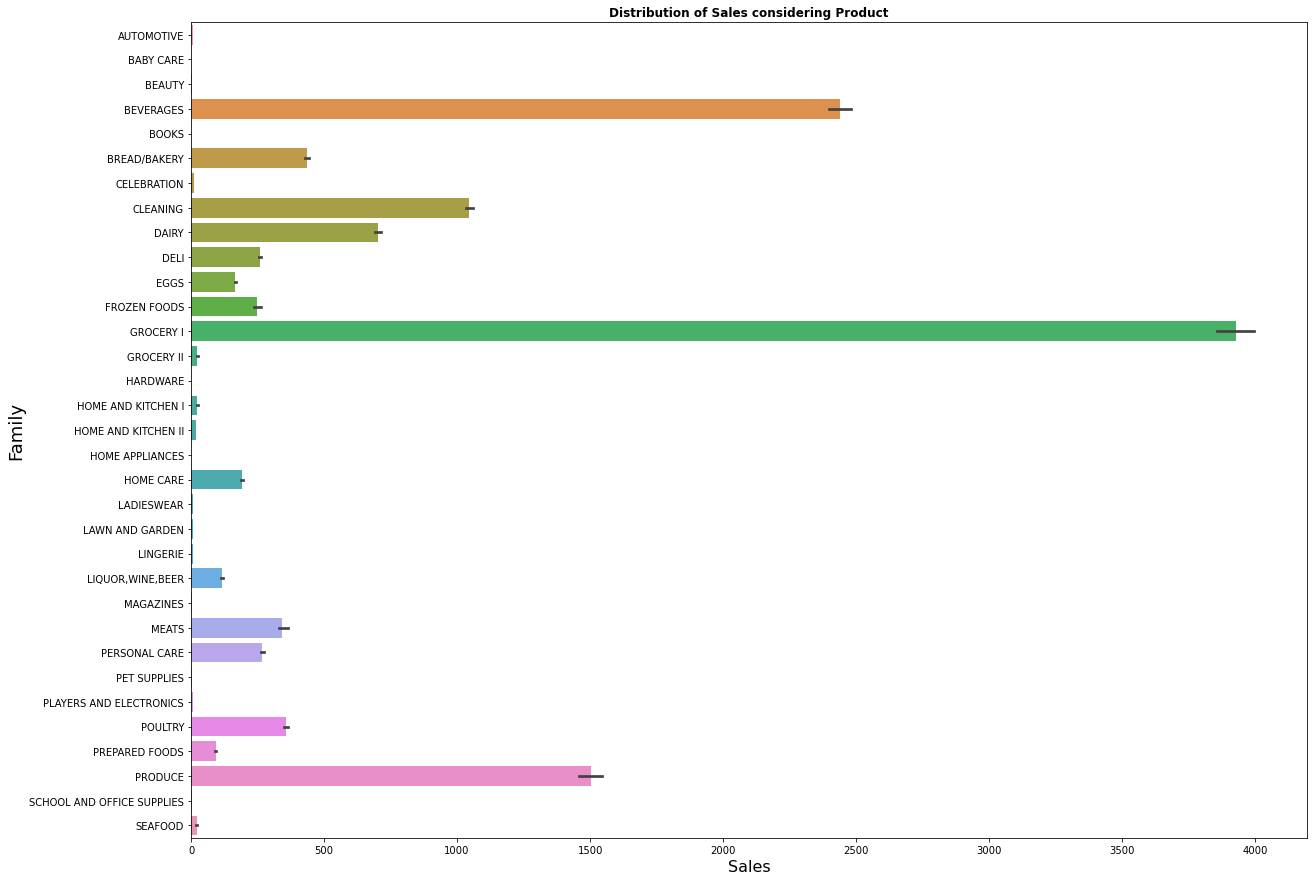

In [82]:
plt.figure(figsize=(20, 15))

sns.barplot(x='sales',y='family',data=train)
plt.title('Distribution of Sales considering Product',fontweight="bold")
plt.ylabel('Family', fontsize=18)
plt.xlabel('Sales', fontsize=16)

Text(0.5, 0, 'Sales')

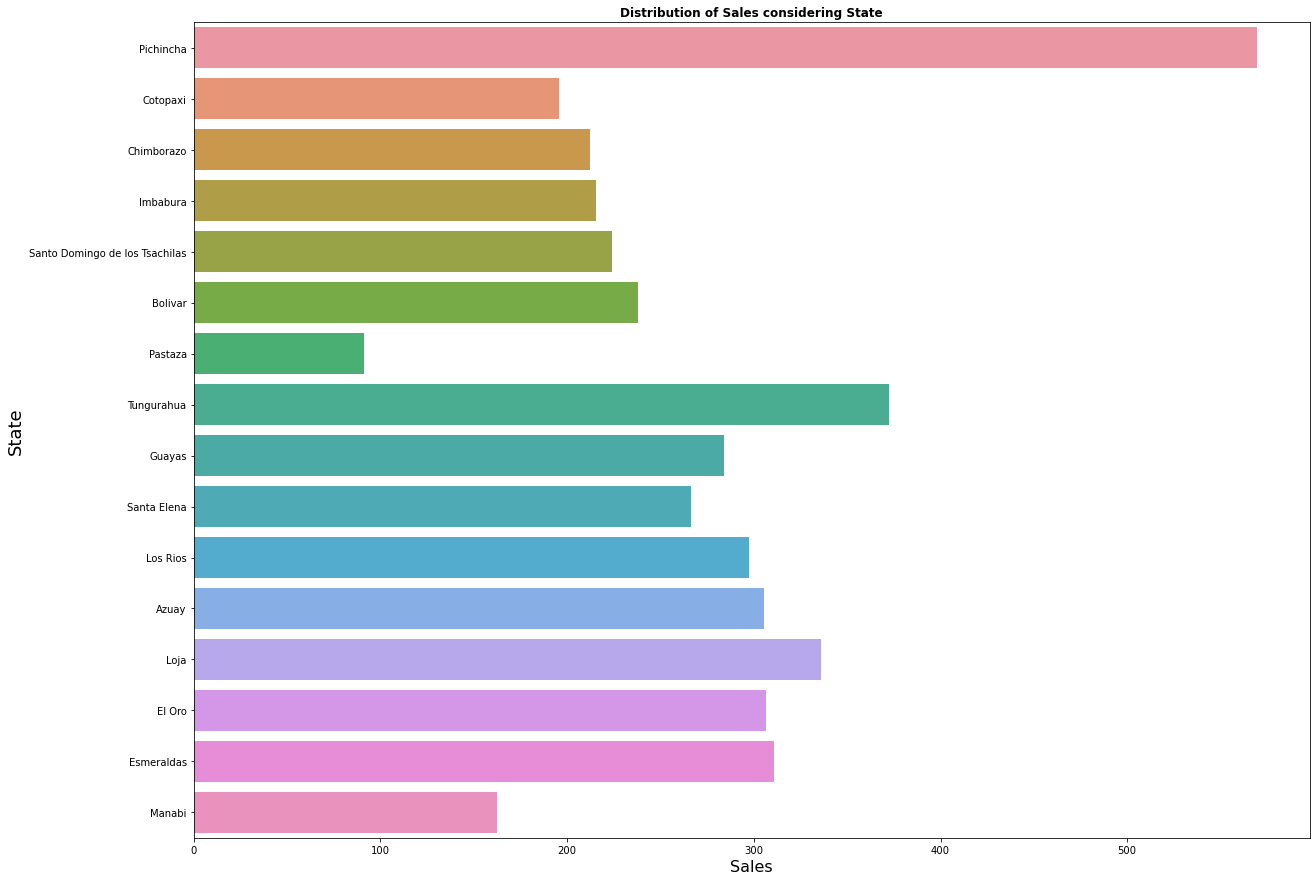

In [83]:
plt.figure(figsize=(20, 15))

sns.barplot(x='sales',y='state',data=train, ci=None)
plt.title('Distribution of Sales considering State',fontweight="bold")
plt.ylabel('State', fontsize=18)
plt.xlabel('Sales', fontsize=16)

Text(0.5, 0, 'Sales')

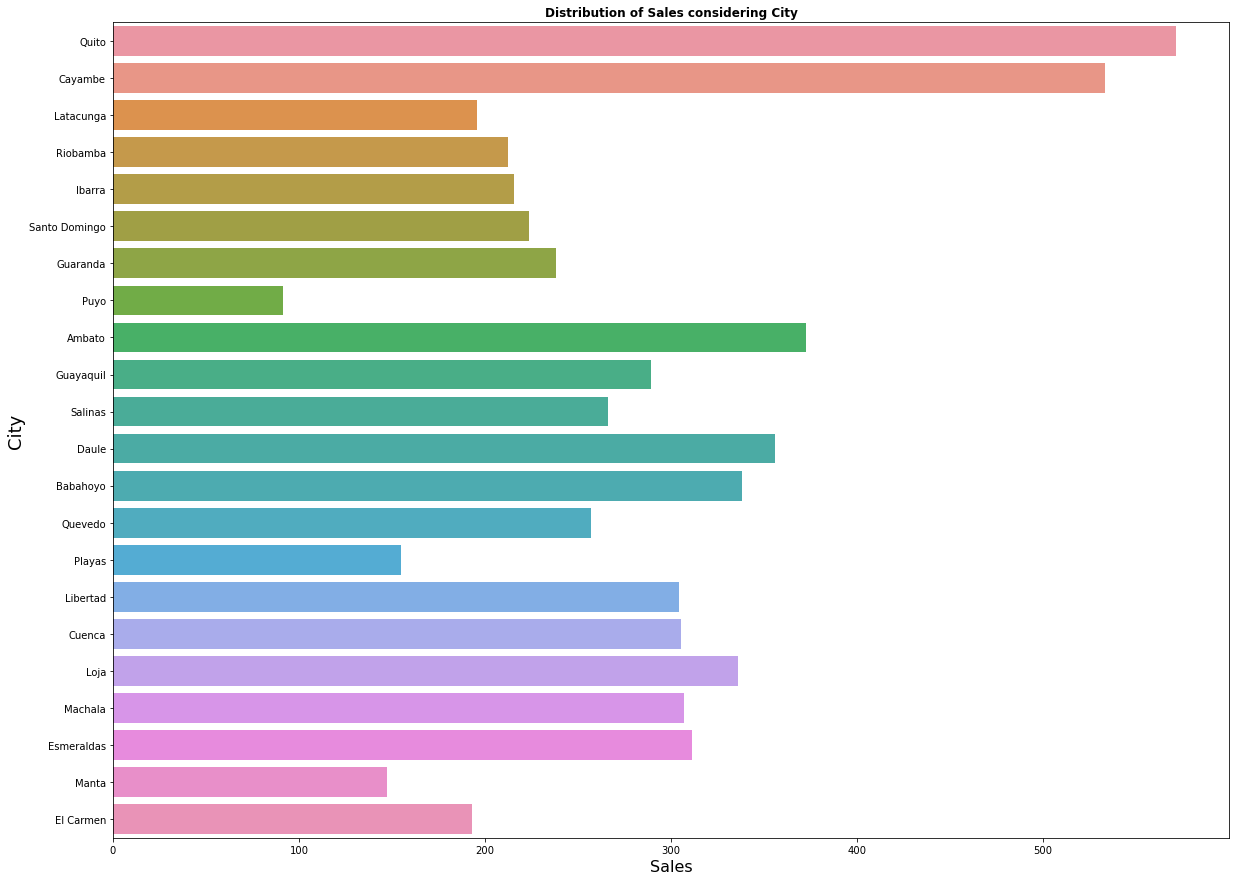

In [84]:
plt.figure(figsize=(20, 15))

sns.barplot(x='sales',y='city',data=train, ci=None)
plt.title('Distribution of Sales considering City',fontweight="bold")
plt.ylabel('City', fontsize=18)
plt.xlabel('Sales', fontsize=16)

In [85]:
train

,id,date,store_nbr,family,sales,onpromotion,oil_price,holiday_type,transferred,city,state,store_type,cluster,Year,Year-Month,Month,Day
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
1,1,2013-01-01,1,BABY CARE,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
2,2,2013-01-01,1,BEAUTY,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
3,3,2013-01-01,1,BEVERAGES,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
4,4,2013-01-01,1,BOOKS,0.000,0,NaN,Holiday,False,Quito,Pichincha,D,13,2013,2013-01,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352831,3000883,2017-08-15,9,POULTRY,438.133,0,47.57,Holiday,False,Quito,Pichincha,B,6,2017,2017-08,8,15
352832,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,47.57,Holiday,False,Quito,Pichincha,B,6,2017,2017-08,8,15
352833,3000885,2017-08-15,9,PRODUCE,2419.729,148,47.57,Holiday,False,Quito,Pichincha,B,6,2017,2017-08,8,15
352834,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,47.57,Holiday,False,Quito,Pichincha,B,6,2017,2017-08,8,15


# 3. Modeling

### 3.1 Model A_Time Series Model

### 3.1.1 What's time series forcasting?

Time series forcasting occurs when you make scientific predictions based on historical timestamp data.It involves building models through historical analysis and using them to observe and promote future strategic decisions.

### 3.1.2 Plotting for statistics summary (checking outliers,sampling distribution)

This part contains plotting of distribution of sales by year (which indicates outliers) and seasonal plot of sales.
Also, the sample data is randomedly drawed.

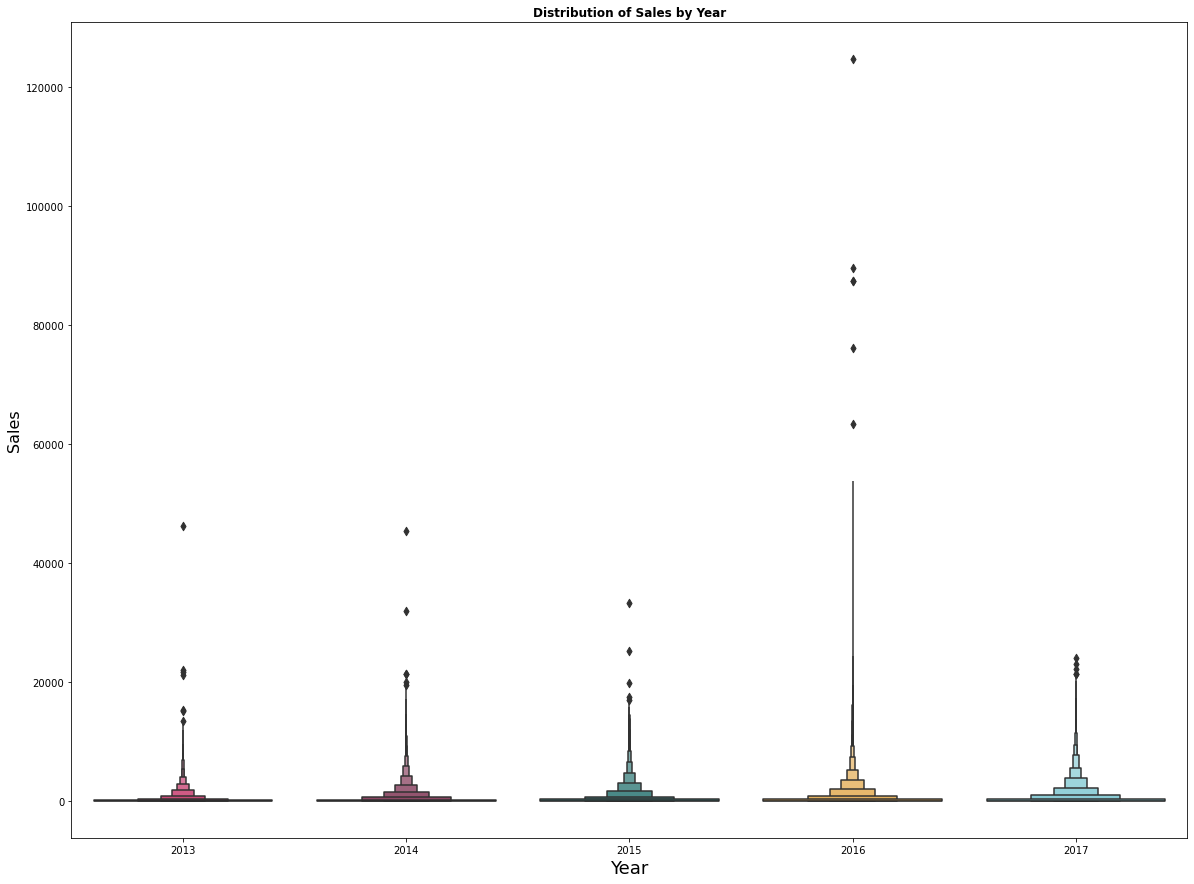

In [86]:
plt.figure(figsize=(20, 15))
sns.boxenplot(x = "Year", y = "sales", 
              data = train,palette=my_color_palette)
plt.title('Distribution of Sales by Year',fontweight="bold")
plt.xlabel('Year', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.show()

As seen from the graph above, there are some obvious outliers in the original sales dataset, which can be removed for further analysis.

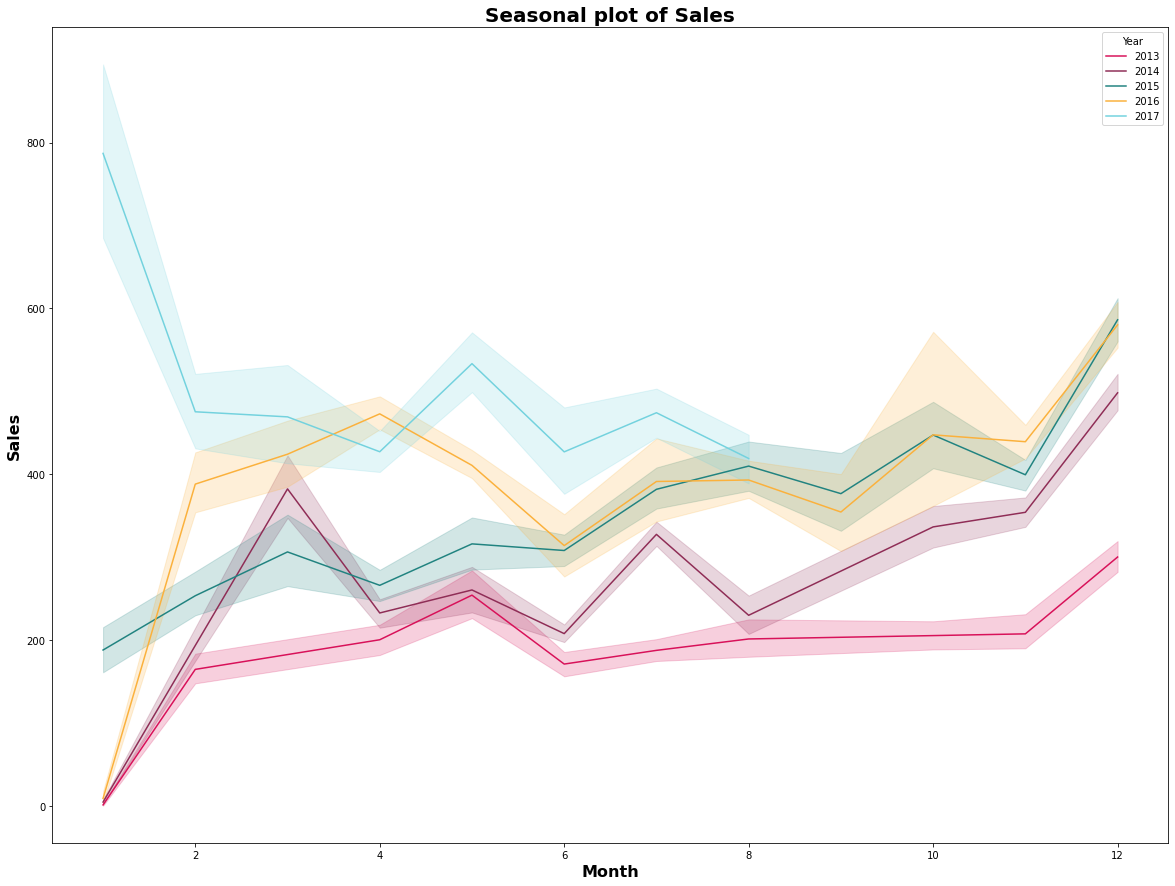

In [32]:
plt.figure(figsize=(20, 15)) 
sns.lineplot(train['Month'], train['sales'], hue=train['Year'], palette=my_color_palette)
plt.title('Seasonal plot of Sales', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
plt.xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
plt.ylabel('Sales', fontsize = 16, fontdict=dict(weight='bold'))
plt.show()

In [33]:
ts=train.groupby(['date'])["sales"].sum()

### 3.1.3 Rolling Mean and Rolling Standard Deviation

Rolling means creating a rolling window with a specified size and perform calculations on the data in this window which, of course, rolls through the data.

Moving Standard Deviation is a statistical measurement of market volatility. It makes no predictions of market direction, but it may serve as a confirming indicator.

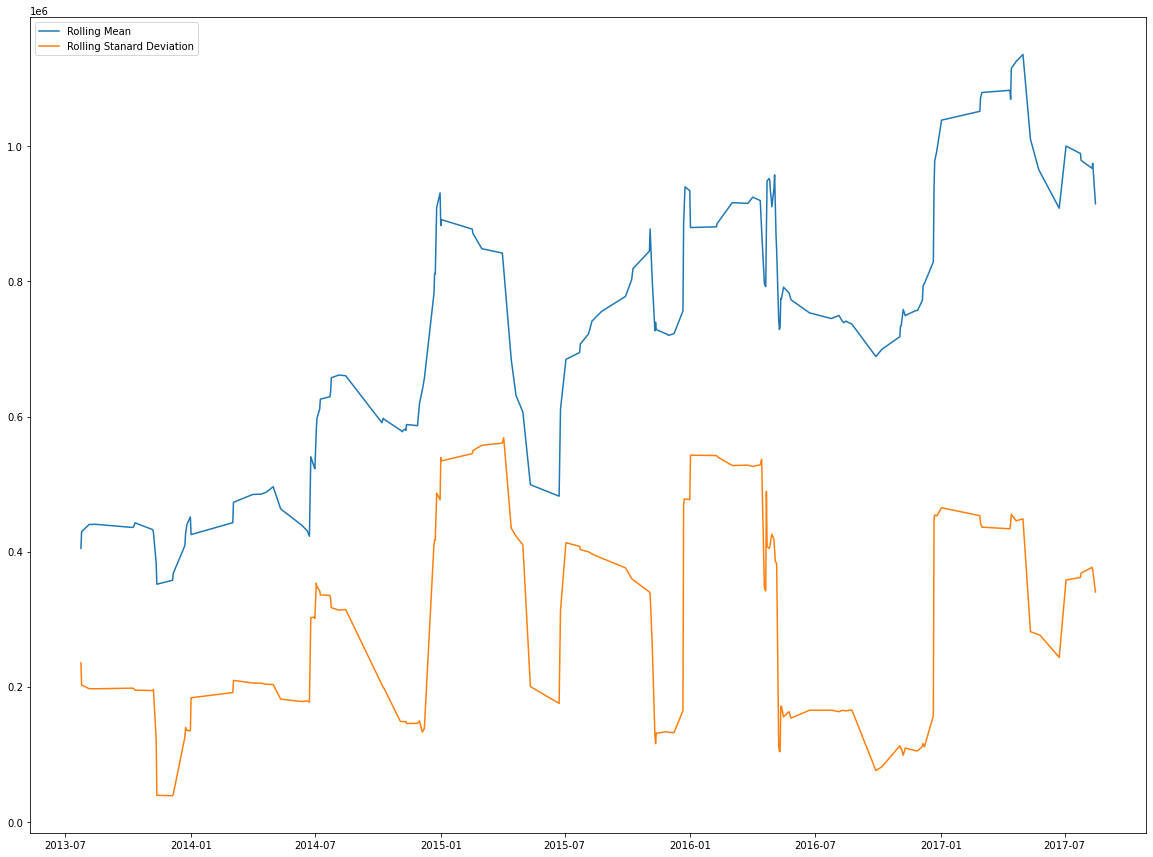

In [34]:
plt.figure(figsize=(20, 15)) 
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling Stanard Deviation');
plt.legend();

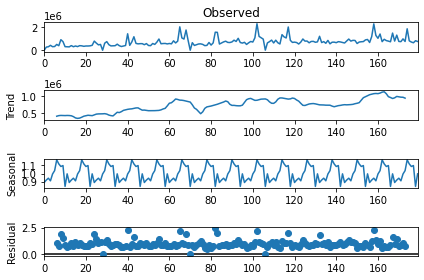

In [35]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

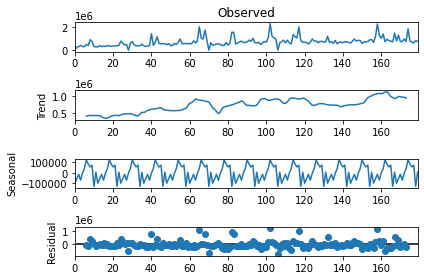

In [36]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [103]:
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import datetime

### 3.1.4 Forecasting and prediction using Time Series Analysis

In [167]:
target_month = datetime.datetime.strptime('2017-02', '%Y-%m').date()
train['Year-Month'] = pd.to_datetime(train['Year-Month']).dt.date
train_time = train[(train['Year-Month'] < target_month)]
train_time['train'] = train['sales']
test_time = train[(train['Year-Month'] >= target_month)]
test_time['test'] = train['sales']
new_train = pd.DataFrame(train_time['Year-Month'])
new_train['train'] = train_time['train']
new_test=pd.DataFrame(test_time['Year-Month'])
new_test['test'] = test_time['test']
del new_train['Year-Month']
del new_test['Year-Month']
new_train = new_train.sample(n=10)
new_test = new_test.sample(n=10)

In [168]:
from pmdarima.arima import auto_arima
model = auto_arima(new_train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(new_train)
forecast = model.predict(n_periods=len(new_test))
forecast = pd.DataFrame(forecast,index = new_test.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=155.592, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=157.139, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=157.306, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=156.385, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.474 seconds


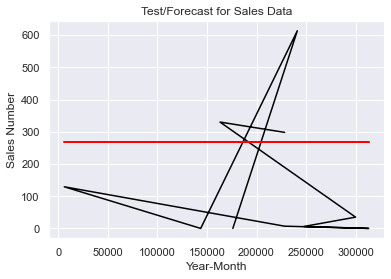

In [169]:
plt.plot(new_test, color = "black")
plt.plot(forecast, color = "red")
plt.title("Test/Forecast for Sales Data")
plt.ylabel("Sales Number")
plt.xlabel('Year-Month')
sns.set()
plt.show()

### 3.1.4 RMSE Results

In [170]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(new_test,forecast))
print("RMSE: ", rms)

RMSE:  234.95702184706036


### 3.1.5 Stationarity test using Dickey-Fuller Test

In [38]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -5.118187
p-value                          0.000013
#Lags Used                       3.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


### 3.1.6 Preliminary Conclusion of Model A Time Series

Statistics: 
Here we observed a p-value of 0.000013 to the Dickey-Fuller test, which is very close to 0 and far less than 0.05, so that we could reject the null hypothesis and consider data as stationary.

A time series is said to be stationary if its statistical properties do not change over time. In other words, it has constant mean and variance, and covariance is independent of time. 

Seasonality:
Seasonality refers to periodic fluctuations. By examining the seasonal plot of sales, we can easily find out seasonal fluctuations in sales. We then check that with a quick decomposition into trend, seasonality and residuals. An increasing trend of sales shown in the plots. Seasonal fluctuations are quite clear in the plots. The residual points are almost all on a horizontal line.

Data Trend:
By running single time series model, we find an increasing trend of sales, and clear seasonal fluctuations, and residuals which are around 0.

Overall, we  get a robust single time series model by decomposing the trend, seasonality, and residuals and we observe strong seasonality in sales data and consider data to be stationary.

Prediction and forecasting accuracy:The final RMSE result for model A time series is 234.95702184706036.



### 3.2 Model A_XGBoost

### 3.2.1 What's XGBoost?

XGBoost is a distributed gradient improvement library that is optimized for efficiency, flexibility, and portability. It uses the Gradient Boosting framework to create a machine learning method. Parallel tree promotion (also known as GBDT, GBM) is a feature of XGBoost that may address a variety of data science issues rapidly and accurately. The same code works in a variety of distributed platforms (Hadoop, SGE, MPI) and can handle problems with billions of possible solutions.

### 3.2.2 Merging Data and Model Training

We merge data from train.csv and store.csv according to store_number.

We merge store dataset and train dataset and consider multiple variables: city, state, onpromotion,family,type,family,cluster, day_item_purchased,month_item_purchased,quarter_item_purchased and year_item_purchased as independent variables.Sales data are considered dependent variables into the model to train the model.

In [1]:
import numpy as np
import pandas as pd
import gc
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split

In [2]:
n = 3000888 # number of records in file
s = 1000 # sample size
select = sorted(random.sample(range(1, n + 1), s))
skip  = tuple(set(range(1, n + 1)) - set(select))

In [3]:
train = pd.read_csv("./final_dataset/train.csv",skiprows = skip)

In [4]:
test  = pd.read_csv("./final_dataset/test.csv")
store = pd.read_csv("./final_dataset/stores.csv")
holiday = pd.read_csv("./final_dataset/holidays_events.csv")
oil = pd.read_csv("./final_dataset/oil.csv")
transaction = pd.read_csv("./final_dataset/transactions.csv")

In [5]:
merged = pd.merge(train, store, on= "store_nbr")
merged = pd.merge(merged, holiday, on="date")
merged = pd.merge(merged, oil, on ="date")

In [6]:
merged.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred,dcoilwtico
0,1905790,2015-12-08,32,CLEANING,357.0,0,Guayaquil,Guayas,C,3,Holiday,Local,Loja,Fundacion de Loja,False,37.46
1,1905291,2015-12-08,19,BEVERAGES,2277.0,0,Guaranda,Bolivar,C,15,Holiday,Local,Loja,Fundacion de Loja,False,37.46
2,2132099,2016-04-14,32,BEAUTY,1.0,0,Guayaquil,Guayas,C,3,Holiday,Local,Libertad,Cantonizacion de Libertad,False,41.45
3,2492070,2016-11-02,32,DELI,131.0,5,Guayaquil,Guayas,C,3,Holiday,National,Ecuador,Dia de Difuntos,False,45.32
4,2830655,2017-05-12,32,HARDWARE,0.0,0,Guayaquil,Guayas,C,3,Holiday,Local,Puyo,Cantonizacion del Puyo,False,47.83


In [7]:
merged.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,type_y,locale,locale_name,description,transferred,dcoilwtico
0,1905790,2015-12-08,32,CLEANING,357.0,0,Guayaquil,Guayas,C,3,Holiday,Local,Loja,Fundacion de Loja,False,37.46
1,1905291,2015-12-08,19,BEVERAGES,2277.0,0,Guaranda,Bolivar,C,15,Holiday,Local,Loja,Fundacion de Loja,False,37.46
2,2132099,2016-04-14,32,BEAUTY,1.0,0,Guayaquil,Guayas,C,3,Holiday,Local,Libertad,Cantonizacion de Libertad,False,41.45
3,2492070,2016-11-02,32,DELI,131.0,5,Guayaquil,Guayas,C,3,Holiday,National,Ecuador,Dia de Difuntos,False,45.32
4,2830655,2017-05-12,32,HARDWARE,0.0,0,Guayaquil,Guayas,C,3,Holiday,Local,Puyo,Cantonizacion del Puyo,False,47.83


In [8]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [9]:
transaction.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [10]:
print(len(merged['family'].unique()))

33


In [11]:
holiday.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [12]:
oil_nan = (oil.isnull().sum() / oil.shape[0]) * 100
oil_nan

date          0.000000
dcoilwtico    3.530378
dtype: float64

In [13]:
store_nan = (store.isnull().sum() / store.shape[0]) * 100
store_nan

store_nbr    0.0
city         0.0
state        0.0
type         0.0
cluster      0.0
dtype: float64

In [14]:
train_nan = (train.isnull().sum() / train.shape[0]) * 100
train_nan

id             0.0
date           0.0
store_nbr      0.0
family         0.0
sales          0.0
onpromotion    0.0
dtype: float64

In [15]:
merged['onpromotion'] = merged['onpromotion'].fillna(2)
merged['onpromotion'] = merged['onpromotion'].replace(True,1)
merged['onpromotion'] = merged['onpromotion'].replace(False,0)

In [16]:
(merged['onpromotion'].unique())

array([ 0,  5, 46,  2,  4,  9,  8,  3,  6, 70,  1, 15, 40, 12, 36, 28, 19,
        7], dtype=int64)

In [17]:
merged['dcoilwtico'] = merged['dcoilwtico'].fillna(0)

In [18]:
merged['Year']  = merged['date'].apply(lambda x: int(str(x)[:4]))
merged['Month'] = merged['date'].apply(lambda x: int(str(x)[5:7]))
merged['date']  = merged['date'].apply(lambda x: (str(x)[8:]))


test['Year']  = test['date'].apply(lambda x: int(str(x)[:4]))
test['Month'] = test['date'].apply(lambda x: int(str(x)[5:7]))
test['date']  = test['date'].apply(lambda x: (str(x)[8:]))

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,2618,2013-01-02,32,FROZEN FOODS,13.575,0
1,15823,2013-01-09,52,HOME AND KITCHEN II,0.000,0
2,16551,2013-01-10,23,HOME CARE,0.000,0
3,22123,2013-01-13,3,GROCERY II,50.000,0
4,25404,2013-01-15,21,PLAYERS AND ELECTRONICS,0.000,0


In [19]:
train_items1 = pd.merge(train, store, how='inner')
train_items2 = pd.merge(train, store, how='inner')

In [20]:
train_items1

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,2618,2013-01-02,32,FROZEN FOODS,13.575,0,Guayaquil,Guayas,C,3
1,528303,2013-10-24,32,CELEBRATION,0.000,0,Guayaquil,Guayas,C,3
2,982728,2014-07-07,32,LINGERIE,0.000,0,Guayaquil,Guayas,C,3
3,1267845,2014-12-14,32,HOME CARE,118.000,0,Guayaquil,Guayas,C,3
4,1577899,2015-06-07,32,BOOKS,0.000,0,Guayaquil,Guayas,C,3
...,...,...,...,...,...,...,...,...,...,...
995,2368981,2016-08-25,29,EGGS,131.000,0,Guayaquil,Guayas,E,10
996,2524023,2016-11-20,29,HOME CARE,377.000,9,Guayaquil,Guayas,E,10
997,2561456,2016-12-11,29,PREPARED FOODS,95.694,2,Guayaquil,Guayas,E,10
998,2693326,2017-02-24,29,SCHOOL AND OFFICE SUPPLIES,0.000,0,Guayaquil,Guayas,E,10


In [21]:
train_items1['date'] = pd.to_datetime(train_items1['date'], format = '%Y-%m-%d')
train_items1['day_item_purchased'] = train_items1['date'].dt.day
train_items1['month_item_purchased'] =train_items1['date'].dt.month
train_items1['quarter_item_purchased'] = train_items1['date'].dt.quarter
train_items1['year_item_purchased'] = train_items1['date'].dt.year
train_items1.drop('date', axis = 1, inplace = True)

In [22]:
train_items2['date'] = pd.to_datetime(train_items2['date'], format = '%Y-%m-%d')
train_items2['day_item_purchased'] = train_items2['date'].dt.day
train_items2['month_item_purchased'] = train_items2['date'].dt.month
train_items2['quarter_item_purchased'] = train_items2['date'].dt.quarter
train_items2['year_item_purchased'] = train_items2['date'].dt.year
train_items2.drop('date', axis = 1, inplace = True)

In [23]:
train_items1.loc[(train_items1.sales<0),'sales'] = 1 
train_items1['sales'] =  train_items1['sales'].apply(pd.np.log1p) 
train_items1['family'] = train_items1['family'].astype('category')
train_items1['city'] = train_items1['city'].astype('category')
train_items1['state'] = train_items1['state'].astype('category')
train_items1['type'] = train_items1['type'].astype('category')
category_columns = train_items1.select_dtypes(['category']).columns
train_items1[category_columns] = train_items1[category_columns].apply(lambda x: x.cat.codes)

C:\Users\Yuton\AppData\Local\Temp/ipykernel_18504/1905154965.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  train_items1['sales'] =  train_items1['sales'].apply(pd.np.log1p)


In [24]:
train_items1

,id,store_nbr,family,sales,onpromotion,city,state,type,cluster,day_item_purchased,month_item_purchased,quarter_item_purchased,year_item_purchased
0,2618,32,11,2.679308,0,8,6,2,3,2,1,1,2013
1,528303,32,6,0.000000,0,8,6,2,3,24,10,4,2013
2,982728,32,21,0.000000,0,8,6,2,3,7,7,3,2014
3,1267845,32,18,4.779123,0,8,6,2,3,14,12,4,2014
4,1577899,32,4,0.000000,0,8,6,2,3,7,6,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2368981,29,10,4.882802,0,8,6,4,10,25,8,3,2016
996,2524023,29,18,5.934894,9,8,6,4,10,20,11,4,2016
997,2561456,29,29,4.571551,2,8,6,4,10,11,12,4,2016
998,2693326,29,31,0.000000,0,8,6,4,10,24,2,1,2017


In [25]:
train_items2.loc[(train_items2.sales<0),'sales'] = 1 
train_items2['sales'] =  train_items2['sales'].apply(pd.np.log1p) 
train_items2['family'] = train_items2['family'].astype('category')
train_items2['city'] = train_items2['city'].astype('category')
train_items2['state'] = train_items2['state'].astype('category')
train_items2['type'] = train_items2['type'].astype('category')
category_columns = train_items2.select_dtypes(['category']).columns
train_items2[category_columns] = train_items2[category_columns].apply(lambda x: x.cat.codes)

C:\Users\Yuton\AppData\Local\Temp/ipykernel_18504/1003859556.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  train_items2['sales'] =  train_items2['sales'].apply(pd.np.log1p)


In [26]:
train_items1 = train_items1.drop(['id','store_nbr','sales'], axis = 1)
train_items1.head()

train_items2 = train_items2.drop(['id','store_nbr','onpromotion','city', 'state', 'type','cluster', 'day_item_purchased','month_item_purchased','quarter_item_purchased','year_item_purchased','family'], axis = 1)
train_items2.head()



,sales
0,2.679308
1,0.000000
2,0.000000
3,4.779123
4,0.000000


In [27]:
Xg_train, Xg_valid = train_test_split(train_items1, test_size=0.012, random_state=10)
Yg_train, Yg_valid = train_test_split(train_items2, test_size=0.012, random_state=10)
features1 = list(train_items1.columns.values)
features2 = list(train_items2.columns.values)

In [28]:
features1

['family',
 'onpromotion',
 'city',
 'state',
 'type',
 'cluster',
 'day_item_purchased',
 'month_item_purchased',
 'quarter_item_purchased',
 'year_item_purchased']

In [29]:
features2

['sales']

In [30]:
dtrain = xgb.DMatrix(Xg_train[features1], Yg_train[features2])
dvalid = xgb.DMatrix(Xg_valid[features1], Yg_valid[features2])

In [31]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

In [32]:
def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    y1 = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

In [33]:
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }
num_boost_round = 15
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

In [34]:
progress = dict()
gbm = xgb.train(params, dtrain, num_boost_round, evals_result=progress, evals = watchlist,
  early_stopping_rounds = 5, feval = rmspe_xg, verbose_eval = True)

[10:48:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:2.71603	train-rmspe:inf	eval-rmse:2.86160	eval-rmspe:inf
[1]	train-rmse:2.06780	train-rmspe:inf	eval-rmse:2.20775	eval-rmspe:inf
[2]	train-rmse:1.68044	train-rmspe:inf	eval-rmse:1.88161	eval-rmspe:inf
[3]	train-rmse:1.41412	train-rmspe:inf	eval-rmse:1.77581	eval-rmspe:inf
[4]	train-rmse:1.20215	train-rmspe:inf	eval-rmse:1.65146	eval-rmspe:inf


D:\software\Anaconda\lib\site-packages\xgboost\training.py:35: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(
C:\Users\Yuton\AppData\Local\Temp/ipykernel_18504/3965242263.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(np.mean((yhat / y-1) ** 2))


### 3.2.3 RMSE results

In [35]:
print("The eval rmse value is")
print(progress['eval']['rmse'])

The eval rmse value is
[2.861604912382364, 2.207749324353888, 1.8816144555057648, 1.7758071062594623, 1.6514595541396466, 1.3579511185510056]


In [36]:
print("Validating")
yhat = gbm.predict(xgb.DMatrix(Xg_valid[features1]))
error = rmspe(Yg_valid.sales.values, np.expm1(yhat))

Validating


C:\Users\Yuton\AppData\Local\Temp/ipykernel_18504/3965242263.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.sqrt(np.mean((yhat / y-1) ** 2))


### 3.2.4 K-fold Cross Validation using XGBoost

In [37]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}
cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[10:48:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[10:48:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,3.469177,0.122104,3.468836,0.266933
1,3.277639,0.081885,3.290411,0.290316
2,3.068911,0.072257,3.089832,0.274922
3,2.945067,0.067412,2.971569,0.282962
4,2.818845,0.054753,2.843198,0.250506


In [39]:
print((cv_results["test-rmse-mean"]).tail(1))

49    1.600005
Name: test-rmse-mean, dtype: float64


From this test we can see that the RMSE is gradually decreasing as the folding training continues, eventually reaching a predicted gap of 1.546 sales per 1000 at the 15th attempt.

### 3.2.5 Visualize Boosting Trees and Feature Importance

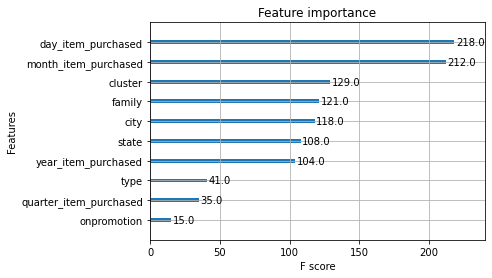

In [41]:
import matplotlib.pyplot as plt
xgb.plot_importance(gbm)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### 3.2.6 Preliminary Conclusion of Model B XGBoost

During 27 trainings, the RMSE of the model decreased from original 2.86 to later 1.35.

In ten-fold cross validation, the model ultimately reached the accuracy of 1.600 error per 1000 sales.

After plotting the model's feature, we found that cluster,day_item_purchased and month_item purchased are the three independent variables that have the most significant influence on sales.


### 3.3 Model C_Linear Regression

### 3.3.1 What is linear regression？

Linear regression is a frequently used statistical analysis method that employs regression analysis in mathematical statistics to identify the quantitative relationship between two or more variables. In regression analysis, only one independent variable and one dependent variable are included, and the relationship between them can be approximated by a straight line. This regression analysis is called unary linear regression analysis. Multiple linear regression analysis is used when the regression analysis contains two or more independent variables and the relationship between the dependent and independent variables is linear.

In Python it has the advantage that the results are easy to understand and computationally uncomplicated. Also the nonlinear data fitting which is not good is the drawback.

### 3.3.2 Modeling for linear regression

In [42]:
import numpy as np
import pandas as pd
import gc
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split
from datetime import datetime
import time

In [43]:
n = 3000888 # number of records in file
s = 1000 # sample size
select = sorted(random.sample(range(1, n + 1), s))
skip  = tuple(set(range(1, n + 1)) - set(select))

In [45]:
df_holiday_events = pd.read_csv('./final_dataset/holidays_events.csv',parse_dates =['date'])
df_oil = pd.read_csv('./final_dataset/oil.csv',parse_dates =['date'])
df_stores = pd.read_csv('./final_dataset/stores.csv')
df_test = pd.read_csv('./final_dataset/test.csv',parse_dates =['date'])
df_train = pd.read_csv('./final_dataset/train.csv',parse_dates =['date'], skiprows=skip)
df_transactions = pd.read_csv('./final_dataset/transactions.csv',parse_dates =['date'])

In [46]:
df_train.tail()

,id,date,store_nbr,family,sales,onpromotion
995,2993165,2017-08-11,41,SEAFOOD,11.0,3
996,2993833,2017-08-12,11,CLEANING,1453.0,22
997,2996313,2017-08-13,30,GROCERY I,1938.0,51
998,2997606,2017-08-14,17,HOME CARE,283.0,7
999,2997965,2017-08-14,27,HARDWARE,1.0,0


In [47]:
df_train.family = pd.Categorical(df_train.family)
df_train['family_code'] = df_train.family.cat.codes
df_train.head(100)

,id,date,store_nbr,family,sales,onpromotion,family_code
0,1443,2013-01-01,49,MEATS,0.000,0,24
1,11520,2013-01-07,32,BEVERAGES,156.000,0,3
2,13592,2013-01-08,4,PREPARED FOODS,83.460,0,29
3,14322,2013-01-09,11,AUTOMOTIVE,6.000,0,0
4,23634,2013-01-14,22,CELEBRATION,0.000,0,6
...,...,...,...,...,...,...,...
95,274771,2013-06-04,19,GROCERY II,1.000,0,13
96,275695,2013-06-04,44,GROCERY II,40.000,0,13
97,281023,2013-06-07,43,POULTRY,61.368,0,28
98,282328,2013-06-08,30,GROCERY II,10.000,0,13


In [48]:
train_liner = pd.merge(train, store, how='inner')
train_liner['date'] = pd.to_datetime(train_liner['date'], format = '%Y-%m-%d')
train_liner['day_item_purchased'] = train_liner['date'].dt.day
train_liner['month_item_purchased'] =train_liner['date'].dt.month
train_liner['quarter_item_purchased'] = train_liner['date'].dt.quarter
train_liner['year_item_purchased'] = train_liner['date'].dt.year
train_liner.drop('date', axis = 1, inplace = True)
train_liner.loc[(train_liner.sales<0),'sales'] = 1 
train_liner['sales'] =  train_liner['sales'].apply(pd.np.log1p) 
train_liner['family'] = train_liner['family'].astype('category')
train_liner['city'] = train_liner['city'].astype('category')
train_liner['state'] = train_liner['state'].astype('category')
train_liner['type'] = train_liner['type'].astype('category')
category_columns = train_liner.select_dtypes(['category']).columns
train_liner[category_columns] = train_liner[category_columns].apply(lambda x: x.cat.codes)

C:\Users\Yuton\AppData\Local\Temp/ipykernel_18504/691868217.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  train_liner['sales'] =  train_liner['sales'].apply(pd.np.log1p)


In [49]:
train.tail()

,id,date,store_nbr,family,sales,onpromotion
995,2995215,2017-08-12,5,BEVERAGES,1353.000,6
996,2995965,2017-08-13,20,PLAYERS AND ELECTRONICS,16.000,0
997,2996290,2017-08-13,3,"LIQUOR,WINE,BEER",212.000,7
998,3000184,2017-08-15,39,"LIQUOR,WINE,BEER",74.000,5
999,3000633,2017-08-15,51,DELI,217.886,8


In [50]:
train_items1['sales'] = train_items2['sales']
feature_cols = ['family', 'city','onpromotion','state','type','cluster','day_item_purchased','month_item_purchased','quarter_item_purchased','year_item_purchased']
x = train_items1[feature_cols]
y = train_items1['sales']

D:\software\Anaconda\lib\site-packages\seaborn\axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


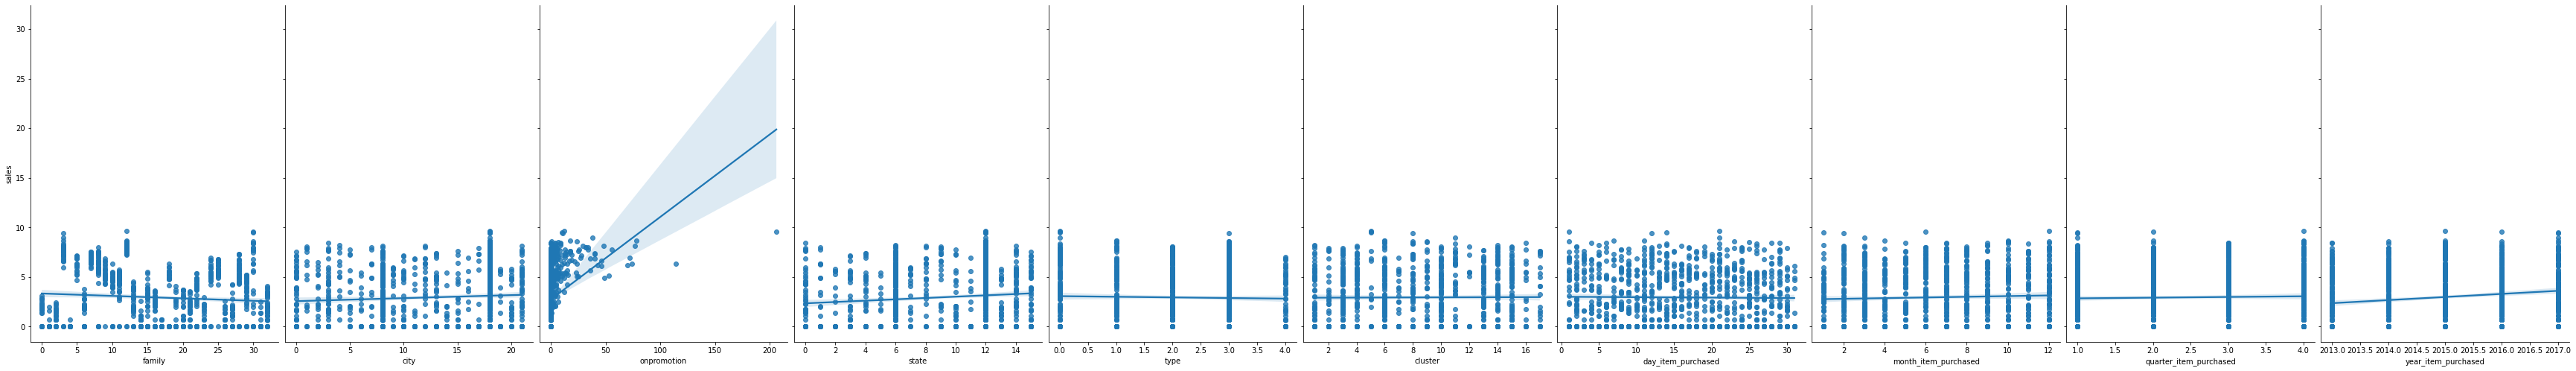

In [51]:
import seaborn as sns
%matplotlib inline

sns.pairplot(train_items1,x_vars=feature_cols,y_vars="sales",size=7,aspect=0.7,kind = 'reg')

In [52]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x, y, random_state=3)

In [53]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [54]:
accuracy = regressor.score(x_test, y_test)
"Accuracy: {}%".format(int(round(accuracy * 100)))

'Accuracy: 11%'

### 3.3.3 Preliminary Conclusion of Model C_Linear Regression

For the store number, family and onpromotion in the training set, the accuracy score of linear regression is 11%, which cannot well predict the change trend of sales. 

Therefore, the testing model cannot well use linear regression method.

# 4. Main Findings and Robustness

### 4.1 Model A_Time Series

Statistics: 
Here we observed a p-value of 0.000013 to the Dickey-Fuller test, which is very close to 0 and far less than 0.05, so that we could reject the null hypothesis and consider data as stationary.

A time series is said to be stationary if its statistical properties do not change over time. In other words, it has constant mean and variance, and covariance is independent of time. 

Seasonality:
Seasonality refers to periodic fluctuations. By examining the seasonal plot of sales, we can easily find out seasonal fluctuations in sales. We then check that with a quick decomposition into trend, seasonality and residuals. An increasing trend of sales shown in the plots. Seasonal fluctuations are quite clear in the plots. The residual points are almost all on a horizontal line.

Data Trend:
By running single time series model, we find an increasing trend of sales, and clear seasonal fluctuations, and residuals which are around 0.

Overall, we  get a robust single time series model by decomposing the trend, seasonality, and residuals and we observe strong seasonality in sales data and consider data to be stationary.

Prediction and forecasting accuracy:The final RMSE result for model A time series is 234.95702184706036.

### 4.1.1 Robustness

We observed a p-value of 0.000013 to the Dickey-Fuller test, which is very close to 0 and far less than 0.05, so that we could reject the null hypothesis and consider data as stationary.


By runnnig single time series model, we find an increasing trend of sales, and clear seasonal fluctuations, and residuals which are around 0.

To conclude, we  get a robust single time series model by decomposing the trend, seasonality, and residuals and we observe strong seasonality in sales data and consider data to be stationary.


### 4.1.2 Pros of Model A_Time Series

1. Visualizing data trend: Time-series analysis is a good way to visualize the trend of sales overtime clearly in a plot. The method would be handy in real life cases with panel data, because researchers can view the data trend more clearly.

2. Seasonality: Time-series analysis can also provide valuable information about seasonality in the research, providing a more in-depth view in the datasets.

3. Simplicity: Time-series only needs endogenous variables and does not rely on other exogenous variables.

### 4.1.3 Cons of Model A_Time Series

1. Time-consuming: Time series takes more effort to make predictions. Because time series is first to analyze historical data and understand the trend, then model and finally forecast as well as predict.

2. Unable to cope with huge deviation of the future and historical data: The model may be overfitted, meaning that a model can lead to inaccurate results, if tremendous change occurs in the future.

3. Poor perfomance in case of complex relationships: Time series analysis is that it does not have many techniques for a large number of variables and complex relationships. The drawback needs researchers to conduct sophiscated modeling and combine different techiniques to reach a more accurate answer.

4. Relatively poor performance in prediction: From the RMSE result (234.95702184706036.),we can see that time series model did not perform very well in this case, which may need more research in modeling, changing parameters and so forth to improve the prediction accuracy, which reinforces the first drawback.

5. May be negatively impacted by outliers: Time series needs stable dataset of high quality to perform well, otherwise the accuracy of preditction may require more differentiation work to stablize the data or identifying and removing outliers. As indicated in our project, datasets with outliers could possibily result in a high RMSE.

### 4.2 Model B_XGBoost

During 27 trainings, the RMSE of the model decreased from original 2.86 to later 1.35.

In ten-fold cross validation, the model ultimately reached the accuracy of 1.600 error per 1000 sales.

After plotting the model's feature, we found that cluster,day_item_purchased and month_item purchased are the three independent variables that have the most significant influence on sales.


### 4.2.1 Robustness

XGBoost and boosting in general are very sensitive to outliers. This is because boosting builds each tree on previous trees' residuals/errors. Outliers will have much larger residuals than non-outliers, so boosting will focus a disproportionate amount of its attention on those points
It depends on how you set your dataset up and the training samples.

That being said, the amount of wrangling and normalization that XGBoost requires tends to give a relatively clean start.

### 4.2.2 Pros of Model B_XGBoost

1. Automatic Feature selection, low computational cost and strong generalization effect:

   XGBoost prediction provides advantages such as automatic Feature selection, low computational cost, and strong    generalization effect when compared to the disadvantages of insufficient logistic regression fitting accuracy and complicated SVM Feature selection. To avoid the overfitting problem, the XGBoost model adds the tree model's complexity to the regular term and participates in the loss function. At the same time, Xgboost eigenvalues can be found automatically on sample processing, for missing samples, to split the direction of "the missing value as a type using the," that is, the missing value data were assigned to the left child losses are calculated respectively in the tree and right subtree, select the best, so try what points in training time, The test can be divided directly according to the empirical optimal, considerably increasing the number of available samples and obviating the requirement to clean the sample data excessively when training the model.

2. Scalability and high flexibility of prediction model:
The XGBoost model has a high degree of scalability. When goods with new ID need to be anticipated in the future, using the data in this project as an example, the model does not need to be retrained, but the sales data of new goods may be imported into the model to obtain good prediction performance. In addition, when new features need to be anticipated, current models can be used to predict them directly, displaying a high degree of flexibility throughout the entire process of prediction.

3. Saves effort and increases accuracy: 
XGBoost is optimization of decision trees, which trains and test every independent variables, eliminates the ones with low correlations while keeping the more relavant ones. This saves time and improves the RMSE in case of uncertainty and unpredictable issues in real life, which can be back up by the RMSE result from our project. (During 27 trainings, the RMSE of the model decreased from original 2.86 to later 1.35. In ten-fold cross validation, the model ultimately reached the accuracy of 1.600 error per 1000 sales.)

### 4.2.3 Cons of Model B_XGBoost

1. Requires efforts in training dataset for iteration:

   When running the XGBoost model, it is necessary to traverse the whole training data set numerous times throughout each iteration. The size of the training data is limited by the fact that it is loaded into memory in its entirety. A significant amount of time will be used reading and writing training data if the data is not placed into memory beforehand.



### 4.3 Model C_Linear Regression

For the store number, family and onpromotion in the training set, the accuracy score of linear regression is 11%, which cannot well predict the change trend of sales. 

Therefore, the testing model cannot well use linear regression method.

### 4.3.1 Robustness

In real world settings, Linear Regression (GLS) underperforms for multiple reasons:
It is sensitive to outliers and poor quality data—in the real world, data is often contaminated with outliers and poor quality data. If the number of outliers relative to non-outlier data points is more than a few, then the linear regression model will be skewed away from the true underlying relationship.
It requires all variables to be multivariate normal (a generalisation of the univariate gaussian to higher dimensions) — transforming non-normal variables to normal using non-linear transformations (e.g. often log-transformation may fix the issue) may introduce effects of multicollinearity.
It assumes there is no (or little) multicollinearity between the variables (i.e. the variables are independent of one another)¹ —this makes the model extremely unstable. Though simple to test and remove, this can be a pain.
It assumes homoscedasticity— that is, the standard deviations of the error terms are constant. They must also be uncorrelated and have zero mean if linear regression is to be the BLUE (Best Linear Unbiased Estimator)

For the store number, family and onpromotion in the training set, the accuracy score of linear regression is 7%, which cannot well predict the change trend of sales. 

Therefore, the testing model cannot well use linear regression method.

### 4.3.2 Pros of Model C_Linear Regression

1. Simplicity
The model and the logic displayed in linear regression is simple to understand and apprehend.

### 4.3.3 Cons of Model C_Linear Regression

1. multicollinearity and time-cosuming:

   During linear regression, variables that may have multicollinearity, which can interfere with the accuracy of prediction, which requires more work on the causality side of reseach.

2. Poor performance with panel data prediction and data visualizing:

   Becasue both XGBoost and Linear Regression have poor robustness, data were processed before training by deleting outliers and performing logarithmic transformation on Sales data. The poor performance of linear regression (11%) may because linear regression cannot incorporate a large number of highly sophistated variables.
   Comparing with Time Series model, linear regression cannot visualize the data trend over a period of time clearly, which can be a drawback in presenting findings in business cases.

# 5. Conclusion

### 5.1 What we've learned from analysis

The best fitting model in the presented project is XGBoost method. 

Model B_ XGBoost:
XGBoost is optimization of decision trees, which trains and test every independent variables, eliminates the ones with low correlations while keeping the more relavant ones. This saves time and improves the RMSE in case of uncertainty and unpredictable issues in real life, which can be back up by the RMSE result from our project. (During 27 trainings, the RMSE of the model decreased from original 2.86 to later 1.35. In ten-fold cross validation, the model ultimately reached the accuracy of 1.600 error per 1000 sales.) The relative low RMSE indicates more accurate prediction result in a more fitting model.

Meanwhile, XGBoost can provide visualized information about features with automatic Feature selection at low computational cost for strong generalization effect. The flexibility and scalability also helps with accurate demand prediction which can be applicable in real life cases. The pros of XGBoost is worth the time and effort put into training datasets for iteration.

Model A_Time Series:
Although we display ARIMA to find the most fitting parameters, but time Series model displays relatively high RMSE of approximately 234.96 and cannot find best fitting parameters efficiently. This may due to existing outliers,unstable dataset caused by exogenous uncertain variables and requires more sophiscated work in modeling and understanding the specific business problem.

However, time series model can visualize data trend in panel data with plots very clearly and help understand seasonality, which can be great information on statistics summary for historical data.

Model C_Linear regression:
As illustrated in the pros and cons of linear regression in section 4.3, linear regression result with an accuracy of 11% indicates poor performace with panel data. 
This means that linear regression approach does not fit our presented case well, and would require sophisticated time and effort to deal with multicollinearity along with other chanllenges in real case to present an accurate prediction.
Also, linear regression approach cannot help researchers visualize and understand the trend of panel data very well comparing with time series approach.


### 5.2 Future Work

1. In the future, we can do more detailed analysis, like incorporating product type or product feather, or trying to include geographic and demographic features to make more comprehensive demand prediction.


2. In addition, we can try to work and improve the quality of time series method against future uncertainty. The dataset provided in this case only contains data prior 2017, so, the analysis of sales volume in recent years does not play a significant role. For example, COVID-19 is a global health emergency which is unpredictable and heavily affects industries over the world negatively. In the future, we can analyze recent data dating to post-pandemic and try to find ways to improve accuracy in case of uncerntainty in Time Series model.

3. Moreover, more research can be done to find a better way of removing outliers and coping with missing values.

4. We can use LSTM to make prediction and see if the results improve further for XGBoost Model, but for that we need to come up with the correct architecture.

# 6. References & Acknowledgements

[1] Yifei Zhang, Dongyuan Mao, Jing Zhao. Grocery Sales Forecasting for Corporacion Favorita. 

[2] Clive S. Morphet (1991) Applying multiple regression analysis to the forecasting of grocery store sales: an application and critical appraisal, The International Review of Retail, Distribution and Consumer Research, 1:3, 329-351, DOI: 10.1080/09593969100000032

[3] Bajari, Patrick, Denis Nekipelov, Stephen P. Ryan, and Miaoyu Yang. 2015. "Machine Learning Methods for Demand Estimation." American Economic Review, 105 (5): 481-85.

[4] Kotler P., Keller K. L., Marketing Management, 2011, pp 115-124.

Data source: Data is provided by Corporación Favorita and found on Kaggle. https://www.kaggle.com/competitions/favorita-grocery-sales-forecasting/data